# Exercise set 9: Double machine learning

In this exercise set we will once again be working with estimation of conditional average treatment effects assuming selection on observables. However, this time the focus will be more broadly on double machine learning in `econml`, learning how to utilize these methods to get estimates, both assuming a partially linear model (`LinearDML`) and non-parametrically using causal forests (`CausalForestDML`).

As an example we will examine the age-old question of orange juice price-elasticity, which, as we all know, have haunted economists for millenia. To answer this question we will use a subset of [Dominick's dataset](
https://www.chicagobooth.edu/research/kilts/datasets/dominicks) from the James M. Kilts Center, University of Chicago Booth School of Business. The data is a repeated cross sectional from stores (which we pool), where our main variables of interest are the amount of units sold (outcome) and the price of orange juice (treatment) and median income in the neighborhood (treatment effect heterogeneity). A description of the dataset can be seen [here](https://rdrr.io/cran/bayesm/man/orangeJuice.html). Throughout, we assume selection on observables. This exercise was in part inspired by the `econml` notebooks on causal model selection and double machine learning.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
import urllib.request

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set seed and plot style
np.random.seed(73)
plt.style.use('seaborn-whitegrid')

%matplotlib inline

## Getting started

In this first part of the exercise we will be digging straight into estimating treatment effects using double machine learning. As such, we will be postponing training of models for predicting `Y` and `T` for just a moment, although this is an essential part of double machine learning and should not be neglected.

> **Exercise 1.1**
>
> Load the data using the following code and verify that you have correctly loaded the `DataFrame` by printing the first 5 rows.
>
> NOTE: The following code will download the file which might take a few seconds dependent on your internet.
>
>>*Hints:*
>> 
>> `DataFrame`'s have a method called .head()

In [2]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Download file")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
    
oj_data = pd.read_csv(file_name)

In [3]:
### BEGIN SOLUTION

oj_data.head()

### END SOLUTION

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


> **Exercise 1.2**
>
> The following code subsets the data into different parts corresponding to `X`, `Y`, `W` and `T`, but have been named temporary names. Which is which, and why?
>
>>*Hints:*
>> 
>> What's just confounders and what drives heterogeneity?

In [233]:
# Prepare data

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

non_categorical_cols = ['feat', 'AGE60', 'EDUC', 'ETHNIC', 'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5']
categorical_cols = ['brand']

temp_1 = scaler.fit_transform(oj_data[non_categorical_cols].values)
temp_2 = scaler.fit_transform(pd.get_dummies(oj_data[categorical_cols]).values)
# Stacks categorical and non categorical variables together
temp_3 = np.hstack([temp_1, temp_2]) 
temp_4 = np.log(oj_data["price"]).values
temp_5 = oj_data['logmove'].values
temp_6 = scaler.fit_transform(oj_data[['INCOME']].values)

X = # FILL IN
W = # FILL IN
Y = # FILL IN
T = # FILL IN

XW = np.hstack([X, W])

Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val, XW_train, XW_val = train_test_split(Y, T, X, W, XW, test_size=.2)

In [4]:
# Prepare data

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

non_categorical_cols = ['feat', 'AGE60', 'EDUC', 'ETHNIC', 'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5']
categorical_cols = ['brand']

temp_1 = scaler.fit_transform(oj_data[non_categorical_cols].values)
temp_2 = scaler.fit_transform(pd.get_dummies(oj_data[categorical_cols]).values)
temp_3 = np.hstack([temp_1, temp_2])

temp_4 = oj_data['logmove'].values
temp_5 = np.log(oj_data["price"]).values

temp_6 = scaler.fit_transform(oj_data[['INCOME']].values)

X = temp_6
W = temp_3
Y = temp_4
T = temp_5

XW = np.hstack([X, W])

Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val, XW_train, XW_val = train_test_split(Y, T, X, W, XW, test_size=.2)

> **Exercise 1.3**
>
> Create an instance of a `LinearDML` and fit it to the training data using default input parameters. 
>
>>*Hints:*
>> 
>> There's an example on [this page](https://econml.azurewebsites.net/spec/estimation/dml.html#when-should-you-use-it)

In [ ]:
# Your code

In [5]:
### BEGIN SOLUTION

from econml.dml import LinearDML

linear_est = LinearDML()
linear_est.fit(Y_train, T_train, X=X_train, W=W_train)

### END SOLUTION

> **Exercise 1.4**
>
> Look at the documentation for `LinearDML`, which can be found [here](https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html#econml.dml.LinearDML). 
>
> How are the models for `Y` and `T` created? Does this explain why the data was scaled?

In [ ]:
# Your answer

In [15]:
### BEGIN SOLUTION

# cross validated LASSO -- sensitive to scaling, hence standardscaling!

### END SOLUTION

> **Exercise 1.5**
>
> Get an estimate of the treatment effect heterogeneity using the `summary` method. Is the sign as expected?

In [ ]:
# Your code

In [6]:
### BEGIN SOLUTION

linear_est.summary()

# Positive slope -- less price sensitive as income increases. Makes sense!

### END SOLUTION

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.155,0.027,5.821,0.0,0.102,0.207
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-2.601,0.026,-98.624,0.0,-2.652,-2.549


> **Exercise 1.6**
>
> Estimate and plot the conditional average treatment effect and the the 95\% confidence interval with the `LinearDML` model on the following `X_test` data, which generates counterfactual income levels ranging from -1 to 1.
>
>
>>*Hints:*
>> 
>> There documentation for `LinearDML` can be found on [this page](https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html#econml.dml.LinearDML). 
>>
>> Try looking for methods that start with `effect`

In [7]:
## Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

# Calculate treatment effect and interval

te_pred_linear = # FILL IN 
te_pred_interval_linear = # FILL IN 

# Plot Orange Juice elasticity as a function of income

plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred_linear, label="Linear model")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

SyntaxError: invalid syntax (1647766146.py, line 9)

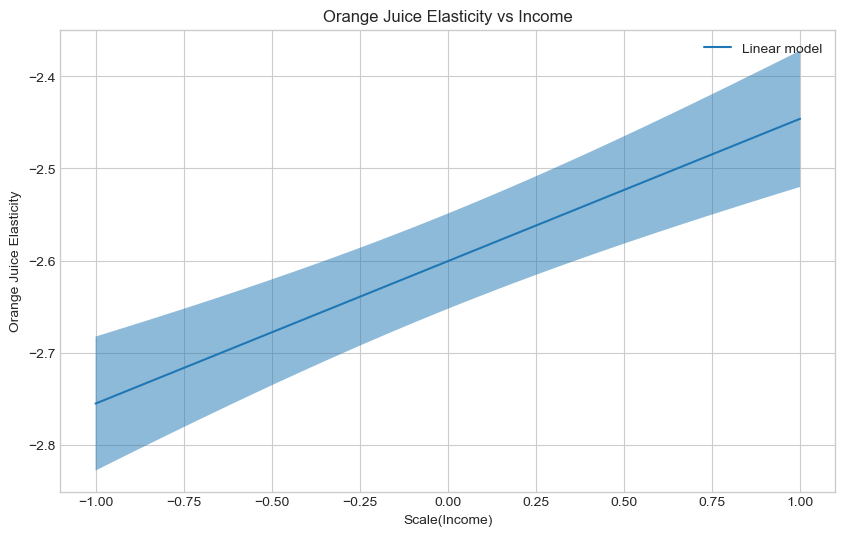

In [8]:
### BEGIN SOLUTION

# Generate test data
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

# Calculate treatment effects

te_pred_linear = linear_est.effect(X_test)
te_pred_interval_linear = linear_est.effect_interval(X_test, alpha = 0.05)

# Plot Orange Juice elasticity as a function of income

plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred_linear, label="Linear model")
plt.fill_between(X_test.flatten(), te_pred_interval_linear[0], te_pred_interval_linear[1], alpha=.5)
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### END SOLUTION

> **Exercise 1.7**
>
> Create an instance of a `CausalForestDML` and fit it to the training data using default input parameters. 
>
>>*Hints:*
>> 
>> It follows exactly the same recipe as `LinearDML`.

In [ ]:
# Your code

In [9]:
### BEGIN SOLUTION

from econml.dml import CausalForestDML

cf_est = CausalForestDML()
cf_est.fit(Y_train, T_train, X=X_train, W=W_train)

### END SOLUTION

> **Exercise 1.8**
>
> Estimate and plot the conditional average treatment effect and the the 95\% confidence interval with the `CausalForestDML` model `X_test`.
>
>
>>*Hints:*
>> 
>> It follows exactly the same recipe as `LinearDML`.

In [ ]:
# Your code

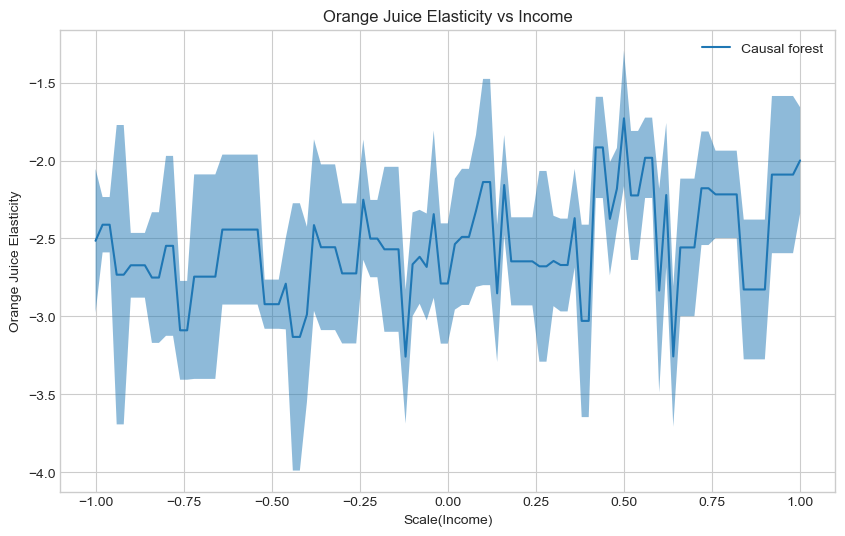

In [10]:
### BEGIN SOLUTION

te_pred_cf = cf_est.effect(X_test)
te_pred_interval_cf = cf_est.effect_interval(X_test, alpha=0.05)

# Plot Orange Juice elasticity as a function of income
plt.figure(figsize=(10,6))


plt.plot(X_test, te_pred_cf, label="Causal forest")
plt.fill_between(X_test.flatten(), te_pred_interval_cf[0], te_pred_interval_cf[1], alpha=.5)
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### END SOLUTION

As discussed during the lecture, we can use the R-loss to evaluate the fit of the conditional average treatment effect and use this to perform causal model selection.

This could be done manually, but much like `grf` in R, `econml` also offers automatic tuning with the `tune` method, which we will utilize to tune the causal forest in `CausalForestDML`.

> **Exercise 1.9**
>
> Create an instance of a `CausalForestDML`, tune it on the training data and then fit it to the training data, all using default input parameters. 
>
>>*Hints:*
>> 
>> The call to `tune` the model looks exactly like the call to `fit` the model.

In [ ]:
# Your code

In [11]:
### BEGIN SOLUTION

from econml.dml import CausalForestDML

cf_tuned_est = CausalForestDML()
cf_tuned_est.tune(Y_train, T_train, X=X_train, W=W_train)
cf_tuned_est.fit(Y_train, T_train, X=X_train, W=W_train)

### END SOLUTION

> **Exercise 1.8**
>
> Estimate and plot the conditional average treatment effect and the the 95\% confidence interval with the tuned `CausalForestDML` model on `X_test`.
>
>
>>*Hints:*
>> 
>> It follows exactly the same recipe as `LinearDML` and an untuned `CausalForestDML`.

In [ ]:
# Your code

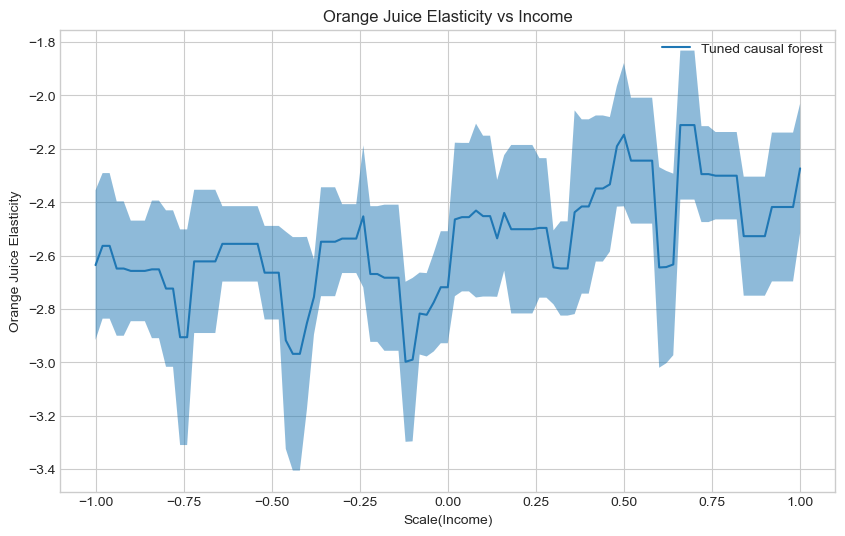

In [12]:
### BEGIN SOLUTION

te_pred_tuned_cf = cf_tuned_est.effect(X_test)
te_pred_interval_tuned_cf = cf_tuned_est.effect_interval(X_test, alpha=0.05)


# Plot Orange Juice elasticity as a function of income
plt.figure(figsize=(10,6))

plt.plot(X_test, te_pred_tuned_cf, label="Tuned causal forest")
plt.fill_between(X_test.flatten(), te_pred_interval_tuned_cf[0], te_pred_interval_tuned_cf[1], alpha=.5)
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

### END SOLUTION

> **Exercise 1.9**
>
> Plot the conditional average treatment effect and the the 95\% confidence interval for all three models on `X_test`. Which do your prefer?
>
>
>>*Hints:*
>> 
>> You can call `plot` and `fill_between` repeatedly before calling `xlabel`

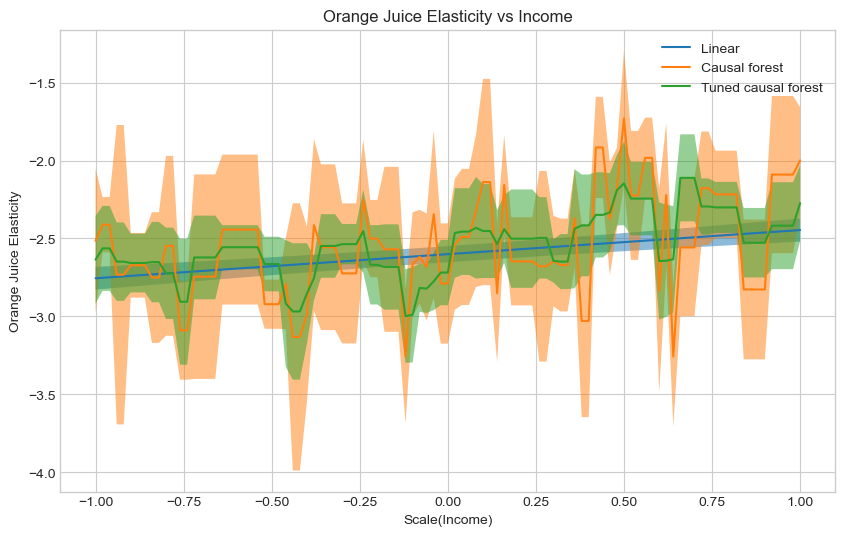

In [13]:
### BEGIN SOLUTION

# Plot Orange Juice elasticity as a function of income
plt.figure(figsize=(10,6))

# Linear
plt.plot(X_test, te_pred_linear, label="Linear")
plt.fill_between(X_test.flatten(), te_pred_interval_linear[0], te_pred_interval_linear[1], alpha=.5)
# Untuned CF
plt.plot(X_test, te_pred_cf, label="Causal forest")
plt.fill_between(X_test.flatten(), te_pred_interval_cf[0], te_pred_interval_cf[1], alpha=.5)
# Tuned CF
plt.plot(X_test, te_pred_tuned_cf, label="Tuned causal forest")
plt.fill_between(X_test.flatten(), te_pred_interval_tuned_cf[0], te_pred_interval_tuned_cf[1], alpha=.5)
# Make pretty
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

# No clear way to tell which is the correct model.
# Given that the tuned causal forest is tuned using the R-loss, 
# I would atleast prefer that over the untuned causal forest

### END SOLUTION

> **Exercise 1.10**
>
> `econml` implements a scoring function using the R-loss, called the `Rscorer`. Fit the `Rscorer` to the appropriate data sample.
>
> NOTE: The `Rscorer` needs a model to create residuals. Here we input a `LassoCV`, which is also the default in the double machine learning models. As such we obtain similar residuals.
>
>>*Hints:*
>> 
>> Should we use training data or held out data for causal model selection?

In [ ]:
# Import model
from sklearn.linear_model import LassoCV
from econml.score import RScorer

# Create scorer
scorer = RScorer(model_y=LassoCV(), model_t=LassoCV())

# FILL IN

In [14]:
### BEGIN SOLUTION

# Import model
from sklearn.linear_model import LassoCV
from econml.score import RScorer

# Create scorer
scorer = RScorer(model_y=LassoCV(), model_t=LassoCV())

scorer.fit(Y_val, T_val, X=X_val, W=W_val)

### END SOLUTION

> **Exercise 1.11**
>
> Score the models using the `Rscorer`'s `best_model` method. Which model is the preferred one? Is it preferred over a constant average treatment effect?
>
>
>>*Hints:*
>> 
>> If you're in doubt as to which model the method has selected, you can return all the scores by setting `return_scores = True` and compare the best score to the list
>>
>> The `best_model` method accepts a list of fitted estimators, and the documentation can be seen [here](https://econml.azurewebsites.net/_autosummary/econml.score.RScorer.html)

In [ ]:
# Your code

In [15]:
### BEGIN SOLUTION

cate_models = [linear_est, cf_est, cf_tuned_est]
best_model, best_score, score_list = scorer.best_model(cate_models, return_scores = True)

print(best_model)
print(best_score)
print(score_list)

# The tuned causal forest is the best model, 
# As it has an rscore of higher than 0, it is preferred over a constant average treatment effect. 
# Although we note that this is very close to zero

### END SOLUTION

0.0011816363186031298
[0.0009297028164834131, -0.001814529865579395, 0.0011816363186031298]


## Predicting treatment and outcome

Having now looked closer at how to code up estimation of heterogeneous treatment effects using double machine learning estimators, we will start with the task that is predicting both `Y` and `T`, from which we can learn the optimal hyperparameters to pass on to our double machine learning estimators.

In practice, this is probably where you will be spending most of the time, optimizing features and models to accurately predict treatment and outcome, thus achieving better converge rates.

We have covered this in both session 3 and 4, where we covered model selection and supervised learning, respectively.

> **Exercise 2.1**
>
> What covariates should we use to predict `Y` and `T`? Is this part of the train test split we made in exercise 1.1?
>
>
>>*Hints:*
>> 
>> Look at the struqtural equations in the lecture slides. What enters in the nuisance functions?


In [ ]:
### BEGIN SOLUTION

# Both Y and T should be predicted using both X and W
# If T was used in predicting Y, we should use a doubly robust estimator, which is not possible for continuous outcomes
# We did perform a horizontal stacking of X and W, called XW, before making our train test split
# We can use XW to create the models

### END SOLUTION

To make this go by slightly faster, I have pre-selected three models and their respective hyperparametergrids for which to search over. Furthermore, we utilize 2 fold cross validation (matching the default amount of folds in `econml`) and 10 random hyperparameter combinations using `RandomizedSearchCV`, which we covered in session 3. 

Each model should be using `negative_mean_squared_error`, and you should make note of the best performing hyper mean squared error, such that you can compare performance across estimators.

> **Exercise 2.2**
>
> Create a `Lasso` to predict the outcome, `Y`.
>
> Save the best hyperparameter combination.
>
>
>>*Hints:*
>> 
>> The best score and best hyperparameter can be found using the methods `best_score_` and `best_param_` respectively.


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn # FILL IN 

pipe_lasso = Pipeline([ 
    # FILL IN 
    ]
    )

param_grid = {'lasso__alpha':np.logspace(-5, 3, 10)}


rs = RandomizedSearchCV(
    # FILL IN
)

# Fit
# FILL IN

# Score
# FILL IN

SyntaxError: invalid syntax (3612000372.py, line 5)

In [16]:
### BEGIN SOLUTION

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

pipe_lasso = Pipeline([ 
    ('lasso', Lasso(random_state=1))
    ]
    )

param_grid = {'lasso__alpha':np.logspace(-5, 3, 10)}


rs = RandomizedSearchCV(estimator=pipe_lasso, 
                  param_distributions=[param_grid], 
                  scoring='neg_mean_squared_error', 
                  cv=2,
                  n_iter = 10,
                  n_jobs=-1,
                  random_state=73)


# Fit
rs.fit(XW_train, Y_train)

# Score
print(rs.best_params_)
print(rs.best_score_)

y_lasso_best_params = rs.best_params_

### END SOLUTION

{'lasso__alpha': 0.0005994842503189409}
-0.7015673056724774


> **Exercise 2.3**
>
> Create a `RandomForestRegressor` to predict the outcome, `Y`.
>
> Save the best hyperparameter combination.
>
>
>>*Hints:*
>> 
>> The best score and best hyperparameter can be found using the methods `best_score_` and `best_param_` respectively.


In [ ]:
from sklearn # FILL IN

pipe_forest = Pipeline([                     
    # FILL IN
    ]
    )


param_grid= [{
    'forest__n_estimators': np.unique(np.logspace(0, 3, 25).astype(int)),
    'forest__max_features': np.arange(0.1, 1.01, 0.1),
    'forest__min_samples_split': np.arange(0.01, 0.2, 0.01),
    'forest__min_samples_leaf':  np.arange(2, 50, 2),
    'forest__max_depth': np.unique(np.logspace(1, 4, 20).astype(int))
    }]

rs = RandomizedSearchCV(
    # FILL IN
)

# Fit
# FILL IN

# Score
# FILL IN

In [17]:
### BEGIN SOLUTION

from sklearn.ensemble import RandomForestRegressor

pipe_forest = Pipeline([                     
    ('forest', RandomForestRegressor())
    ]
    )


param_grid= [{
    'forest__n_estimators': np.unique(np.logspace(0, 3, 25).astype(int)),
    'forest__max_features': np.arange(0.1, 1.01, 0.1),
    'forest__min_samples_split': np.arange(0.01, 0.2, 0.01),
    'forest__min_samples_leaf':  np.arange(2, 50, 2),
    'forest__max_depth': np.unique(np.logspace(1, 4, 20).astype(int))
    }]

rs = RandomizedSearchCV(estimator=pipe_forest, 
                  param_distributions=param_grid, 
                  scoring='neg_mean_squared_error', 
                  cv=2, 
                  n_iter = 10,
                  n_jobs=-1,
                  random_state=73)

# Fit
rs.fit(XW_train, Y_train)

# Score
print(rs.best_params_)
print(rs.best_score_)


y_forest_best_params = rs.best_params_

### END SOLUTION

{'forest__n_estimators': 1000, 'forest__min_samples_split': 0.04, 'forest__min_samples_leaf': 46, 'forest__max_features': 0.4, 'forest__max_depth': 61}
-0.6439130531996966


> **Exercise 2.4**
>
> Create a `HistGradientBoostingRegressor` to predict the outcome, `Y`. 
>
> Save the best hyperparameter combination.
>
> NOTE: The `HistGradientBoostingRegressor` is an efficient model which does gradient boosting.
>
>>*Hints:*
>> 
>> The best score and best hyperparameter can be found using the methods `best_score_` and `best_param_` respectively.


In [ ]:
# Your code

from sklearn # FILL IN

pipe_booster = Pipeline([                     
   # FILL IN
    ]
    )


param_grid= [{
    'booster__min_samples_leaf':  np.arange(2, 50, 2),
    'booster__max_depth': np.unique(np.logspace(1, 4, 20).astype(int)),
    'booster__learning_rate':np.arange(0,1.001,0.1)
    }]

rs = RandomizedSearchCV(
    # FILL IN
)

# Fit
# FILL IN

# Score
# FILL IN


In [18]:
### BEGIN SOLUTION

from sklearn.ensemble import HistGradientBoostingRegressor

pipe_booster = Pipeline([                     
    ('booster', HistGradientBoostingRegressor())
    ]
    )


param_grid= [{
    'booster__min_samples_leaf':  np.arange(2, 50, 2),
    'booster__max_depth': np.unique(np.logspace(1, 4, 20).astype(int)),
    'booster__learning_rate':np.arange(0,1.001,0.1)
    }]

rs = RandomizedSearchCV(estimator=pipe_booster, 
                  param_distributions=param_grid, 
                  scoring='neg_mean_squared_error', 
                  cv=2, 
                  n_iter = 10,
                  n_jobs=-1,
                  random_state=73)

# Fit
rs.fit(XW_train, Y_train)

# Score
print(rs.best_params_)
print(rs.best_score_)

y_booster_best_params = rs.best_params_

### END SOLUTION

{'booster__min_samples_leaf': 46, 'booster__max_depth': 379, 'booster__learning_rate': 0.30000000000000004}
-0.6227261601961838


> **Exercise 2.5**
>
> Which model best predicts `Y`? Create a model of that type with the best hyperparameter combination

In [ ]:
# Your code

In [19]:
### BEGIN SOLUTION

# It's the HistGradientBoostingRegressor (gradient boosted models are very powerful)
# As is has the highest negative mean squared error

# Remove 'booster__' prefix
y_params = {k.split('__')[-1]:v for k,v in y_booster_best_params.items()}

# Create model
best_y = HistGradientBoostingRegressor(**y_params)

### END SOLUTION

> **Exercise 2.6**
> 
> You have now found the model which best predicts `Y`, and now we repeat the same process for `T`
> 
> To find the best model to predict `T`, repeat exercise 2.2 through 2.5 but predicting `T`

In [ ]:
# Your code

In [20]:
### BEGIN SOLUTION

pipe_lasso = Pipeline([ 
    ('lasso', Lasso(random_state=1))
    ]
    )


lambdas =  np.logspace(-5, 3, 10)

rs = RandomizedSearchCV(estimator=pipe_lasso, 
                  param_distributions=[{'lasso__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=2,
                  n_iter = 10,
                  n_jobs=-1,
                  random_state=73)

rs.fit(XW_train, T_train)
print(rs.best_params_)
print(rs.best_score_)

t_lasso_best_params = rs.best_params_

pipe_forest = Pipeline([                     
    ('forest', RandomForestRegressor())
    ]
    )


param_grid= [{
    'forest__n_estimators': np.unique(np.logspace(0, 3, 25).astype(int)),
    'forest__max_features': np.arange(0.1, 1.01, 0.1),
    'forest__min_samples_split': np.arange(0.01, 0.2, 0.01),
    'forest__min_samples_leaf':  np.arange(2, 50, 2),
    'forest__max_depth': np.unique(np.logspace(1, 4, 20).astype(int))
    }]

rs = RandomizedSearchCV(estimator=pipe_forest, 
                  param_distributions=param_grid, 
                  scoring='neg_mean_squared_error', 
                  cv=2, 
                  n_iter = 10,
                  n_jobs=-1,
                  random_state=73)

rs.fit(XW_train, T_train)

print(rs.best_params_)
print(rs.best_score_)

t_forest_best_params = rs.best_params_

pipe_booster = Pipeline([                     
    ('booster', HistGradientBoostingRegressor())
    ]
    )


param_grid= [{
    'booster__min_samples_leaf':  np.arange(2, 50, 2),
    'booster__max_depth': np.unique(np.logspace(1, 4, 20).astype(int)),
    'booster__learning_rate':np.arange(0,1.001,0.1)
    }]

rs = RandomizedSearchCV(estimator=pipe_booster, 
                  param_distributions=param_grid, 
                  scoring='neg_mean_squared_error', 
                  cv=2, 
                  n_iter = 10,
                  n_jobs=-1,
                  random_state=73)

rs.fit(XW_train, T_train)

print(rs.best_params_)
print(rs.best_score_)

t_booster_best_params = rs.best_params_

# Remove 'booster__' prefix
t_params = {k.split('__')[-1]:v for k,v in t_forest_best_params.items()}

# Create best model
best_t = RandomForestRegressor(**t_params)

### END SOLUTION

{'lasso__alpha': 7.742636826811278e-05}
-0.03612321520342247
{'forest__n_estimators': 421, 'forest__min_samples_split': 0.060000000000000005, 'forest__min_samples_leaf': 26, 'forest__max_features': 0.7000000000000001, 'forest__max_depth': 20}
-0.03577823168557294
{'booster__min_samples_leaf': 46, 'booster__max_depth': 379, 'booster__learning_rate': 0.30000000000000004}
-0.03669465435871566


> **Exercise 2.7**
>
> Estimate a `LinearDML` as well as an untuned and tuned `CausalForestDML` using the new models for `T` and `Y`.
> 
> Plot the conditional average treatment effect and the the 95\% confidence interval for all three models on `X_test`. Which do your prefer?

In [ ]:
# Your code

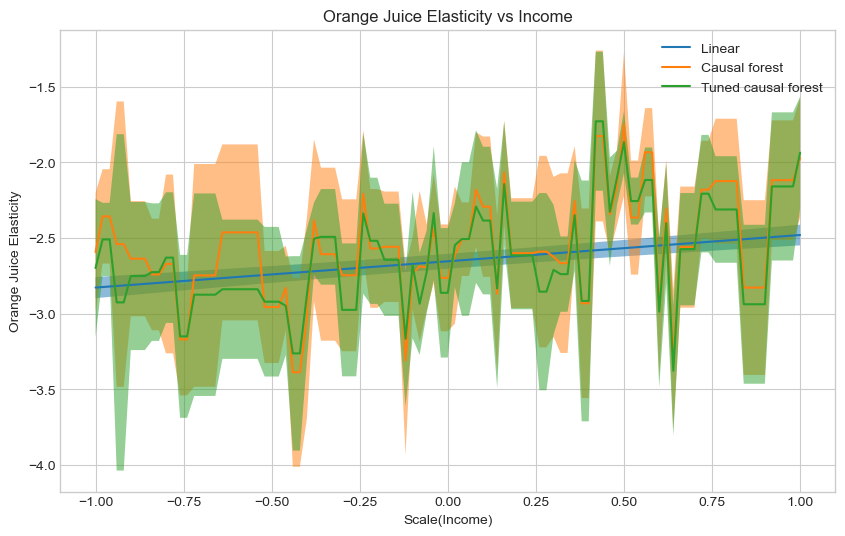

In [21]:
### BEGIN SOLUTION

linear_est_best = LinearDML(model_t=best_t, model_y=best_y)
linear_est_best.fit(Y_train, T_train, X=X_train, W=W_train)

te_pred_linear_best = linear_est_best.effect(X_test)
te_pred_interval_linear_best = linear_est_best.effect_interval(X_test, alpha=0.05)

cf_est_best = CausalForestDML()
cf_est_best.fit(Y_train, T_train, X=X_train, W=W_train)

te_pred_cf_best = cf_est_best.effect(X_test)
te_pred_interval_cf_best = cf_est_best.effect_interval(X_test, alpha=0.05)

cf_tuned_est_best = CausalForestDML(model_t=best_t, model_y=best_y)
cf_tuned_est_best.tune(Y_train, T_train, X=X_train, W=W_train)
cf_tuned_est_best.fit(Y_train, T_train, X=X_train, W=W_train)

te_pred_tuned_cf_best = cf_tuned_est_best.effect(X_test)
te_pred_interval_tuned_cf_best = cf_tuned_est_best.effect_interval(X_test, alpha=0.05)


# Plot Orange Juice elasticity as a function of income
plt.figure(figsize=(10,6))

# Linear
plt.plot(X_test, te_pred_linear_best, label="Linear")
plt.fill_between(X_test.flatten(), te_pred_interval_linear_best[0], te_pred_interval_linear_best[1], alpha=.5)
# Untuned CF
plt.plot(X_test, te_pred_cf_best, label="Causal forest")
plt.fill_between(X_test.flatten(), te_pred_interval_cf_best[0], te_pred_interval_cf_best[1], alpha=.5)
# Tuned CF
plt.plot(X_test, te_pred_tuned_cf_best, label="Tuned causal forest")
plt.fill_between(X_test.flatten(), te_pred_interval_tuned_cf_best[0], te_pred_interval_tuned_cf_best[1], alpha=.5)
# Make pretty
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

# No clear way to tell which is the correct model.
# Given that the tuned causal forest is tuned using the R-loss, 
# I would atleast prefer that over the untuned causal forest

### END SOLUTION

> **Exercise 2.8**
>
> Score the three new models using the `Rscorer`, now predicting the residuals using the models for `T` and `Y. Which model is the preferred one? Is it preferred over a constant average treatment effect?

In [ ]:
# Your code

In [22]:
### BEGIN SOLUTION

scorer = RScorer(model_y=best_y, model_t=best_t)
scorer.fit(Y_val, T_val, X=X_val, W=W_val)

cate_models_extended = [linear_est_best, cf_est_best, cf_tuned_est_best]
best_model_extended, best_score_extended, score_list_extended = scorer.best_model(cate_models_extended, return_scores = True)

print(best_model_extended)
print(best_score_extended)
print(score_list_extended)

# This time linear dml preferred, although again VERY close to 0
# - Would be interesting to run again with more folds at all steps and monte carlo iterations
# - Also more exhaustive model search for Y and Y
# Qualitatively, the conclusion is the same:
# More price sensitive when less income

### END SOLUTION

0.0008682275612443835
[0.0008682275612443835, -0.0029440261518598465, -0.0017967482149718883]


## Finishing thoughts

Today we have examined double machine learning and how to implement these models. 

In practice, you should spend more time creating the models for `T` and `Y`, as they are quintessential in double machine learning. You should also increase the amount of folds in cross validation, as this increases the amount of data to train on when creating residuals. Furthermore, both the models and `Rscorer` support monte carlo iterations, `mc_iters`, which allows you to repeat the same process again with different splits, thus creating less noisy estimates of the residuals. We have not done this today as the running time of these models quite quickly becomes too long for an exercise set.

If you wish to examine linear treatment heterogeneity, you should also look into the input parameters `featurizer` and `treatment_featurizer`, which enables quick and easy interactions of covariates and treatments, possibly in combination with a `SparseLinearDML`. See e.g. [this notebook](https://github.com/microsoft/EconML/blob/main/notebooks/Treatment%20Featurization%20Examples.ipynb)

All of the `econml` functionality that we went through last week can also still be used with our models, e.g. explainability, CATE interpreters and policy learning.

Additionally, you should be aware that `econml` has a folder with notebook examples on their [GitHub](https://github.com/microsoft/EconML/tree/main/notebooks), where you can see the many different possibilities.